In [1]:
from importlib import reload
import os
from time import time

import numpy as np
import scipy as sc
import pandas as pd
from sklearn.decomposition import PCA
from statsmodels.stats.weightstats import _zstat_generic

import torch
print(torch.cuda.is_available())

import pprint
import editdistance

import utils
import tdre
import shifts
import viennarna_shifts as vshifts
import calibrate as cal

import flexs
import flexs.utils.sequence_utils as s_utils

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

False


2023-12-06 01:00:25.396376: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 01:00:25.580135: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-06 01:00:25.580163: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-06 01:00:27.534294: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

<IPython.core.display.Javascript object>

In [33]:
reload(vshifts)
reload(flexs)

landscape_name = 'L50_RNA1'
model_name = 'lin reg' # for plot title
seed_idx = 4
n = 2000
N = 1000
avg_n_mut = 4
noise_sd = 0.02

model_class = flexs.baselines.models.LinearRegression
model_kwargs = {}

# model_class = flexs.baselines.models.RidgeCV
# model_kwargs = {
#     'alphas': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
#     'cv': 5
# }

# model_class = flexs.baselines.models.CNN
# model_kwargs = {
#     'num_filters': 64,
#     'hidden_size': 64,
#     'loss': 'MSE',
#     'batch_size': 512,
# }

explorer = 'adalead'
thresholds = [0.5, 0.3, 0.2, 0.1, 0.05]

t0 = time()
flexsshift = vshifts.FLEXSShift(landscape_name, noise_sd=noise_sd)
trainseqs_n, ytrain_n, calseqs_n, ycal_n, predcal_n, testseqs_list, yseed = flexsshift.get_data(
    n,
    model_class,
    explorer,
    {'threshold': thresholds},
    model_kwargs=model_kwargs,
    n_cal=n - N,
    N=N,
    seed_idx=seed_idx,
    avg_n_mut=avg_n_mut,
    save_fname_prefix=None
)
print(int(time() - t0))

Regression model trained for threshold = 0.5
Designed sequences for threshold = 0.5
Regression model trained for threshold = 0.3
Designed sequences for threshold = 0.3
Regression model trained for threshold = 0.2
Designed sequences for threshold = 0.2
Regression model trained for threshold = 0.1
Designed sequences for threshold = 0.1
Regression model trained for threshold = 0.05
Designed sequences for threshold = 0.05
59


In [34]:
# distances
disttrain_n = [editdistance.eval(flexsshift.problem['starts'][seed_idx], s) for s in trainseqs_n]
df_rows = [[disttrain, 'train'] for disttrain in disttrain_n]
for i, (testseqs_n, _, _) in enumerate(testseqs_list):
    disttest_n = np.array([editdistance.eval(flexsshift.problem['starts'][seed_idx], s) for s in testseqs_n])
    for disttest in disttest_n:
        df_rows.append([disttest, thresholds[i]])
dist_df = pd.DataFrame(df_rows, columns=['distance', 'hyperparameter'])

# predictions
df_rows = [[p, 'validation'] for p in predcal_n]
for i, (testseqs_n, ytest_n, predtest_n) in enumerate(testseqs_list):
    for p in predtest_n:
        df_rows.append([p, thresholds[i]])
pred_df = pd.DataFrame(df_rows, columns=['prediction', 'hyperparameter'])


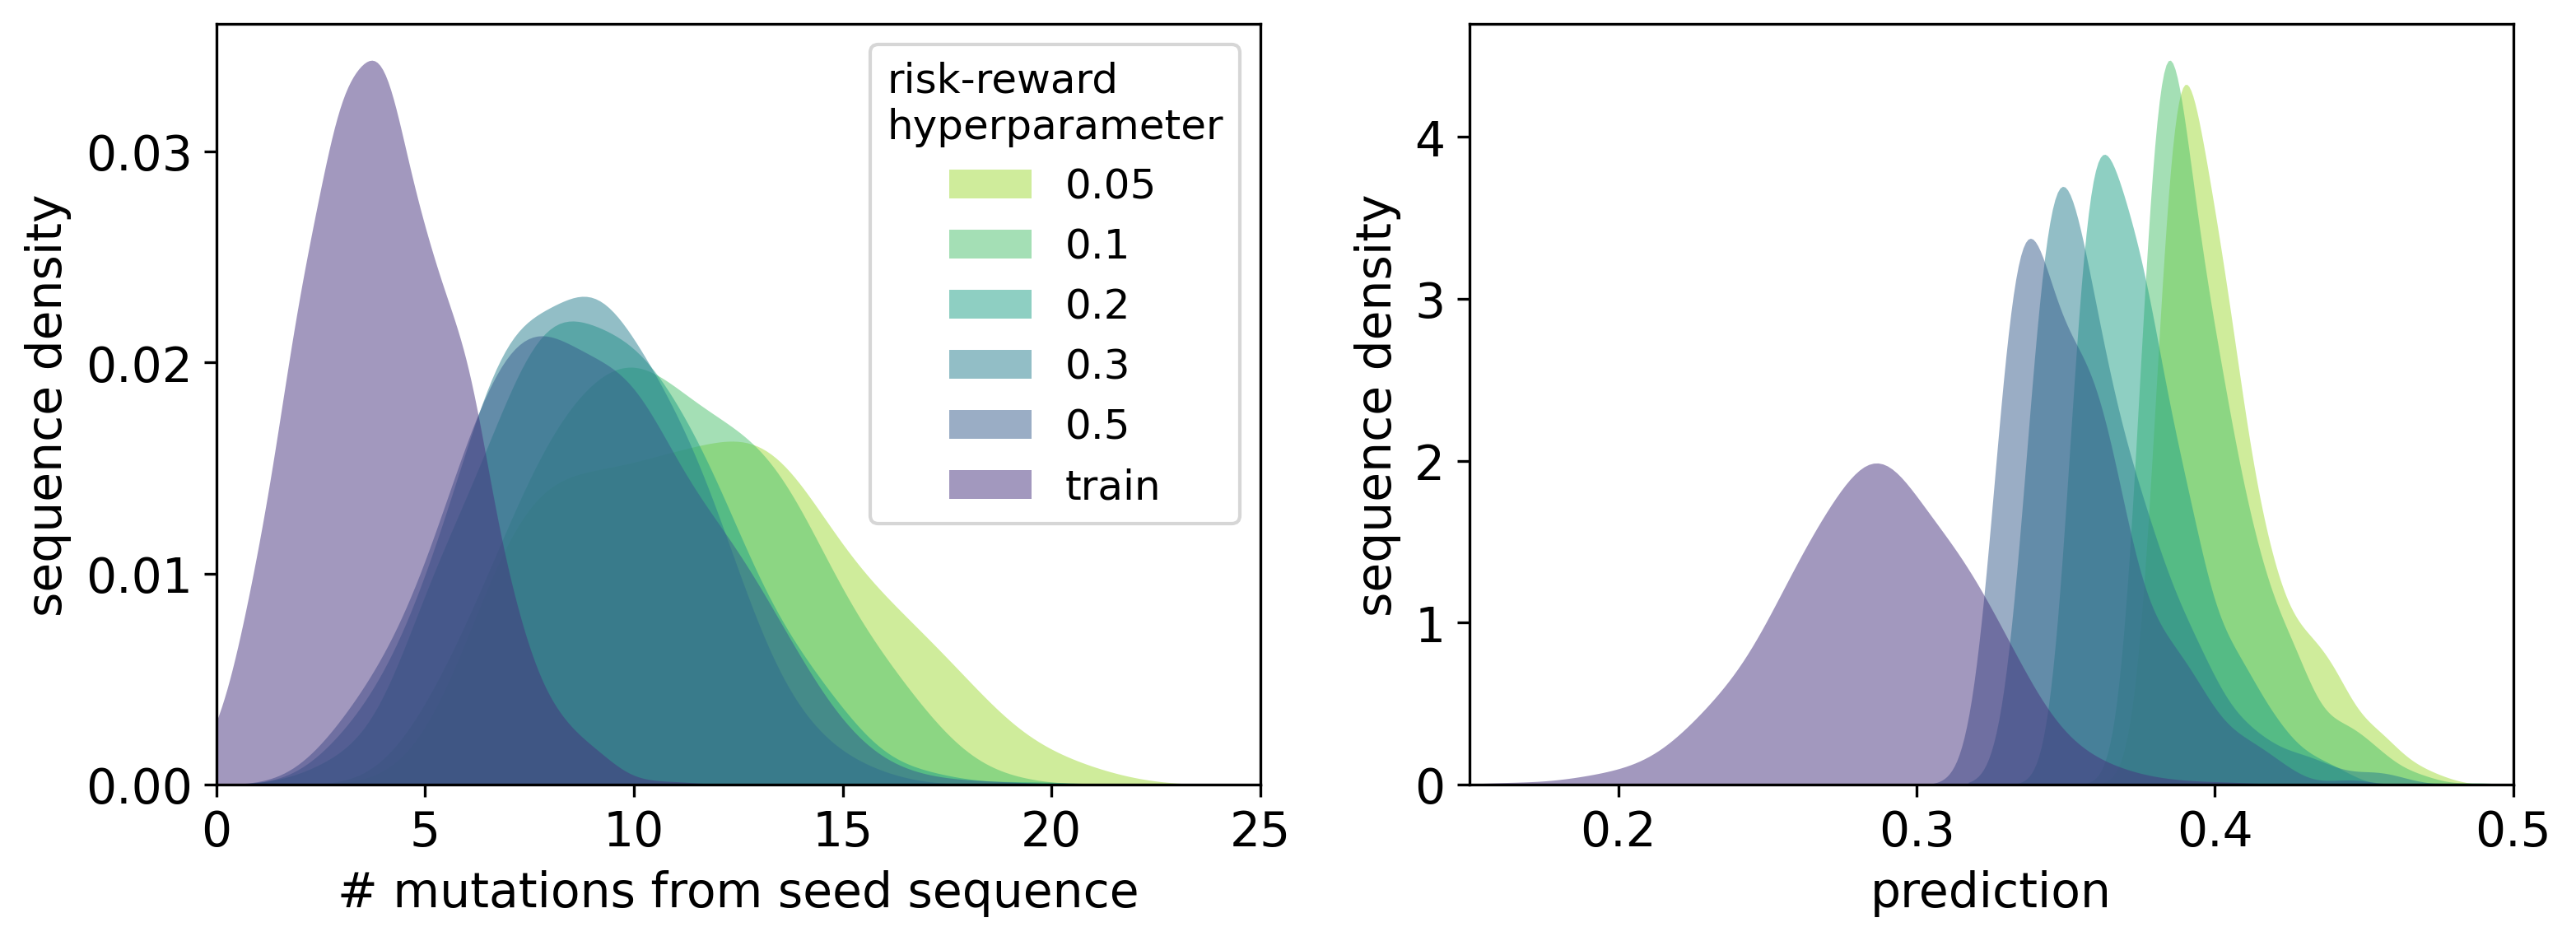

In [75]:
# pretty plot for presentations
scatter_lim = [0.2, 0.5]
n_bins = 12
font = {'size' : 14}
matplotlib.rc('font', **font)
scatter_s = 3
cmap = matplotlib.cm.get_cmap('viridis')

plt.figure(figsize=(12, 4), dpi=300)

plt.subplot(121)
sns.kdeplot(
    dist_df, x='distance', hue='hyperparameter', clip=(0, 50), legend=False,
    hue_order=['train'] + list(thresholds),
    fill=True, linewidth=0, alpha=0.5, palette='viridis', bw_adjust=1.3
)
plt.xlabel('# mutations from seed sequence');
plt.ylabel('sequence density');
plt.xlim([0, 25])
plt.yticks(np.arange(0, 0.031, 0.01));
plt.legend(
    title='risk-reward\nhyperparameter', loc='upper right',
    labels=list(thresholds[::-1]) + ['train'], fontsize=12, title_fontsize=12
);


plt.subplot(122)
sns.kdeplot(
    pred_df, x='prediction', hue='hyperparameter',
    fill=True, linewidth=0, alpha=0.5, palette='viridis', bw_adjust=1.3, legend=False
)
plt.ylabel('sequence density');
plt.xlim([0.15, 0.5]);
plt.xticks(np.arange(0.2, 0.51, 0.1));


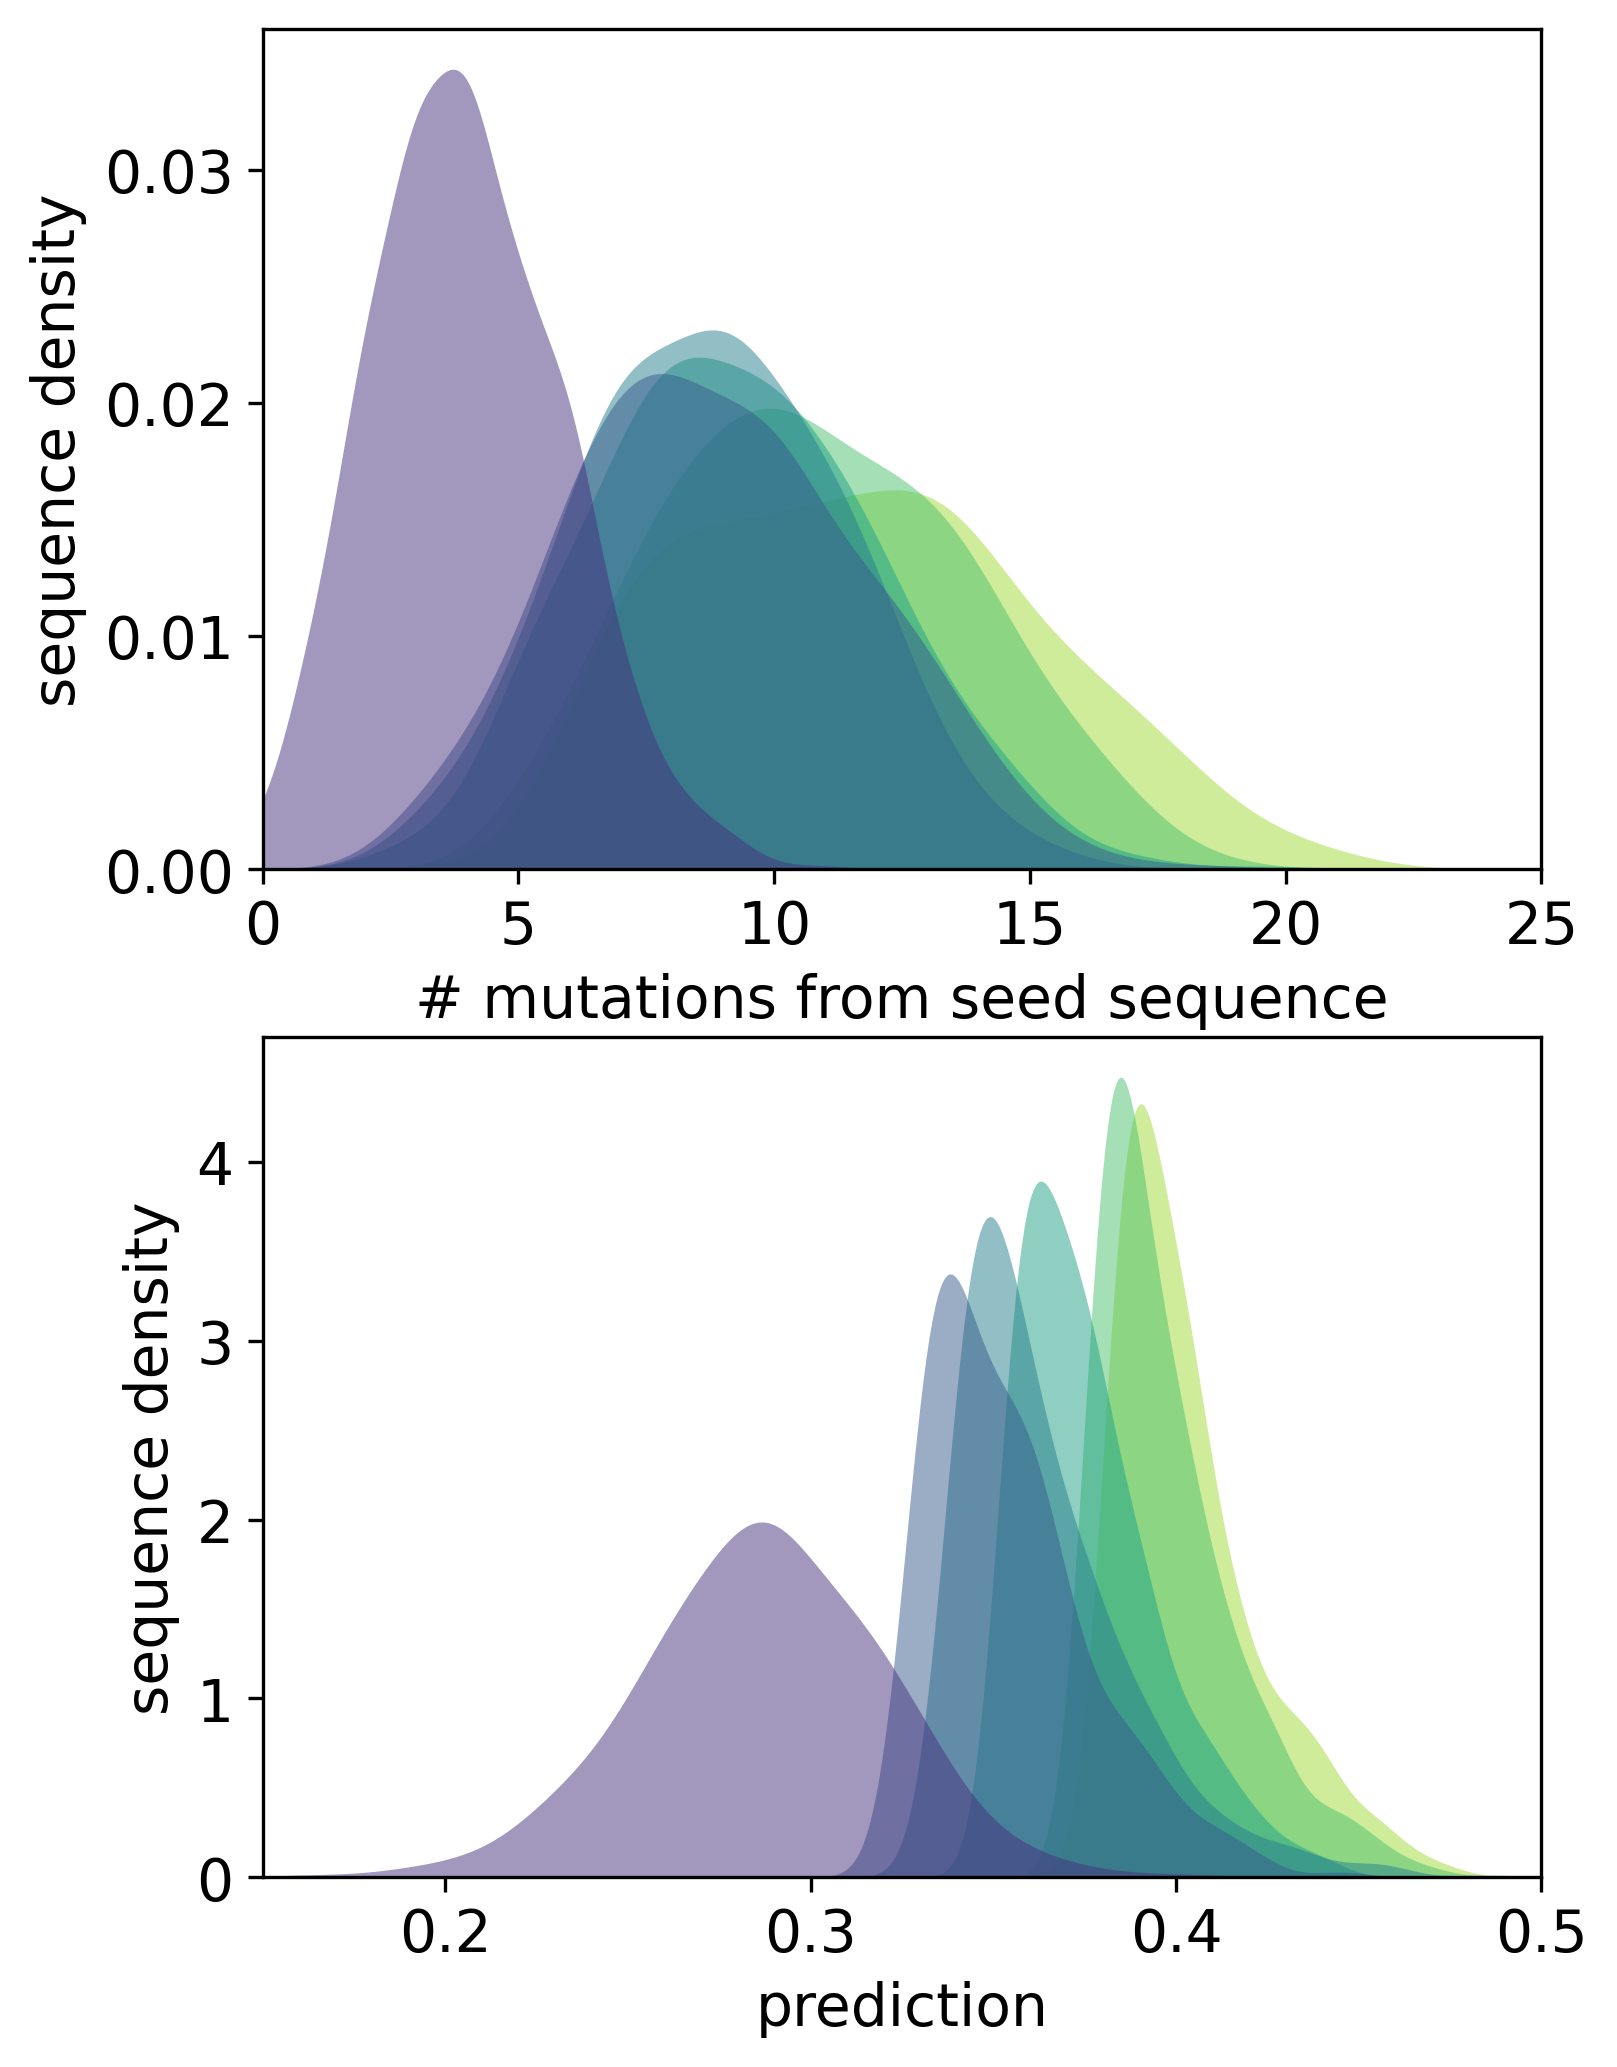

In [90]:
# pretty plot for presentations
scatter_lim = [0.2, 0.5]
n_bins = 12
font = {'size' : 14}
matplotlib.rc('font', **font)
scatter_s = 3
cmap = matplotlib.cm.get_cmap('viridis')

plt.figure(figsize=(5.5, 8), dpi=300)

plt.subplot(211)
sns.kdeplot(
    dist_df, x='distance', hue='hyperparameter', clip=(0, 50), legend=False,
    hue_order=['train'] + list(thresholds),
    fill=True, linewidth=0, alpha=0.5, palette='viridis', bw_adjust=1.3
)
plt.xlabel('# mutations from seed sequence');
plt.ylabel('sequence density');
plt.xlim([0, 25])
plt.yticks(np.arange(0, 0.031, 0.01));
# plt.legend(
#     title='risk-reward\nhyperparameter', loc='upper right',
#     labels=list(thresholds[::-1]) + ['train'], fontsize=12, title_fontsize=12
# );


plt.subplot(212)
sns.kdeplot(
    pred_df, x='prediction', hue='hyperparameter',
    fill=True, linewidth=0, alpha=0.5, palette='viridis', bw_adjust=1.3, legend=False
)
plt.ylabel('sequence density');
plt.xlim([0.15, 0.5]);
plt.xticks(np.arange(0.2, 0.51, 0.1));
